## Addressing Corporate Sustainability Issues Using Natural Language Processing

by Jenica Andersen September 23, 2022

In [1]:
#Necessary imports!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import operator

#import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### Get the Data

In [2]:
# Bring on the Corporate sustainability shareholder resolution data!
#I obtained these manually from https://engagements.ceres.org/?_ga=2.193001133.1671682996.1654368102-1475954746.1654368096
#The resolutions span 2019-2022

df = pd.read_csv(r'shareholder_resolutions_ceres2.csv')
#isolate corpus, perform NLP on the column titled "whereas" (all resolutions begin with Whereas)
text = df.whereas
print(text)

0      In our Company’s 2021 Sustainability Report, C...
1      We believe in full disclosure of Abbott Labora...
2      The political expenditures of AbbVie Inc. appe...
3      Resolved:\nShareholders request Air Products a...
4      The increasing rate and number of climate rela...
                             ...                        
937    Resolved:\nShareholders request that Mondelēz ...
938    Resolved: Shareholders of Mondelez Internation...
939    we believe in full disclosure of Morgan Stanle...
940    Motorola Solutions, Inc., a global corporation...
941    we believe in full disclosure of Motorola Solu...
Name: whereas, Length: 942, dtype: object


In [3]:
df.info()
#there are some null fields. Remove those

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        942 non-null    object
 1   title         942 non-null    object
 2   organization  942 non-null    object
 3   filed_by      940 non-null    object
 4   year          942 non-null    int64 
 5   whereas       923 non-null    object
dtypes: int64(1), object(5)
memory usage: 44.3+ KB


In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921 entries, 0 to 941
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        921 non-null    object
 1   title         921 non-null    object
 2   organization  921 non-null    object
 3   filed_by      921 non-null    object
 4   year          921 non-null    int64 
 5   whereas       921 non-null    object
dtypes: int64(1), object(5)
memory usage: 50.4+ KB


In [7]:
#take a look at how many words we've got in the corpus. The more words we have, the more robust the results.
word_count = df["whereas"].apply(lambda x: len(str(x).split(' ')))
word_count.sum()

407416

#### Preprocessing the data

In [8]:
#Use regex to remove the special characters from the text column, creating a new column called "preprocessed"
df['preprocessed'] = df.whereas.apply(lambda x: (re.sub(r"[^a-zA-Z0-9 ]", " ", x)))
#and remove stand-alone numbers from the preprocessed column
df['preprocessed'] = df.preprocessed.apply(lambda x: (re.sub(r'[0-9]', ' ', x)))
#make all words lowercase
df['preprocessed'] = df['preprocessed'].str.lower()
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...


In [9]:
#Now begin to remove stopwords. Some words appear in the results but do not contribute significantly to interpretations. 
#Make custom list of words to remove, in addition to the common, English stop words.
my_additional_stop_words = ['www', 'whereas', 'include', 'full', 'request', 'resolved',
                            'shareholder','shareholders', 
                            'company', 'companies','use', #'In', 'We', '"We', '"A"', 'The', 'Our', 'For', 
                            'https', 'http', 'pdf', '"I"', 'one', #'abebafb'
                           ]

stop_words = stopwords.words('english')
stop_words2 = list(stop_words)

for word in my_additional_stop_words:
    stop_words2.append(word)

In [10]:
#now create a column with stop words removed    
df['filtered'] = df.preprocessed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words2)]))
df.sample(5)

,status,title,organization,filed_by,year,whereas,preprocessed,filtered
756,Withdrawn: Commitment,Report on supply chain deforestation impacts,Kroger Co.,Green Century Capital Management,2019,"The Kroger Co. (Kroger) utilizes beef, soy, pa...",the kroger co kroger utilizes beef soy pa...,kroger co kroger utilizes beef soy palm oil pu...
235,Vote,Report progress on CA100+ Benchmark indicators,General Motors,As You Sow,2021,The increasing rate and number of climate-rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...
91,Vote,Report on packaging,Jack in the Box Inc,Green Century Capital Management,2022,Plastic pollution is a growing problem globall...,plastic pollution is a growing problem globall...,plastic pollution growing problem globally nin...
605,Withdrawn: Commitment,Report on plastic pollution,Chevron Corporation,As You Sow,2019,Plastic pollution is a global environmental cr...,plastic pollution is a global environmental cr...,plastic pollution global environmental crisis ...
18,Withdrawn: Commitment,Report on lobbying in line with company values...,Amgen Inc.,As You Sow,2022,"The political expenditures of Amgen, Inc. (""Am...",the political expenditures of amgen inc am...,political expenditures amgen inc amgen appear ...


In [11]:
#create a list of the preprocessed and filtered documents for further topic modeling
corpus = list(df.filtered)
#Make sure it is a list, then check its length to be sure the corpus is a list of documents (not all words or letters handled individually)
type(corpus)
len(corpus)

921

In [12]:
#Name the stemmers. I will explore all three. 
#After exploring all three, the Porter stemmer was used in the results. Seems the least aggressive. The Lancaster and Snowball stemmer dtms are further below.
porter = PorterStemmer()
snowball = SnowballStemmer(language = 'english')
lancaster = LancasterStemmer()

Some info from a community member on stemmers from https://intellipaat.com/community/3111/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-algorithms

The main difference between the Porter and Lancaster Stemming algorithms is that the Lancaster stemmer is significantly more dynamic than the Porter Stemmer. 

The three major stemming algorithms in use nowadays:

- Porter Stemmer

- Snowball Stemmer

- Lancaster Stemmer

Porter is the least aggressive algorithm, with the description of each algorithm actually being somewhat lengthy and technical. 

Porter: It is the most commonly used stemmer nowadays. It is one of the few stemmers that actually have Java support and it is also the most computationally intensive of the algorithms. It is also the oldest stemming algorithm by a large margin.

Snowball: This is an improvement over porter. It is slightly faster computation time than porter, with a reasonably large community around it.

Lancaster: It is a very aggressive stemming algorithm. With Porter and Snowball, the stemmed representations are intuitive to a reader, not so with Lancaster, as many shorter words will become totally confusing. The fastest algorithm here, and will reduce your working set of words hugely, but if you want more distinction, not the tool you would want.

I’d suggest that Snowball is better than Porter and Lancaster.

In [13]:
#tokenize the filtered column before stemming
df['tokenized'] = df.filtered.apply(lambda x: RegexpTokenizer("\s+", gaps=True).tokenize(x))#' '.join([word for word in x.split() if word not in (stop_words2)]).porter.stem(x))
#create a column for each stemmer method
df['porter'] = df['tokenized'].apply(lambda x: [porter.stem(y) for y in x]) # Stem every word.
df['lancaster'] = df['tokenized'].apply(lambda x: [lancaster.stem(y) for y in x]) # Stem every word.
df['snowball'] = df['tokenized'].apply(lambda x: [snowball.stem(y) for y in x]) # Stem every word.
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...,sustainability report ceo mike roman states co...,"[sustainability, report, ceo, mike, roman, sta...","[sustain, report, ceo, mike, roman, state, com...","[sustain, report, ceo, mik, rom, stat, commit,...","[sustain, report, ceo, mike, roman, state, com..."
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...,believe disclosure abbott laboratories abbott ...,"[believe, disclosure, abbott, laboratories, ab...","[believ, disclosur, abbott, laboratori, abbott...","[believ, disclos, abbot, lab, abbot, direct, i...","[believ, disclosur, abbott, laboratori, abbott..."
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...,political expenditures abbvie inc appear misal...,"[political, expenditures, abbvie, inc, appear,...","[polit, expenditur, abbvi, inc, appear, misali...","[polit, expendit, abbvy, int, appear, misalign...","[polit, expenditur, abbvi, inc, appear, misali..."
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...,air products address risks opportunities prese...,"[air, products, address, risks, opportunities,...","[air, product, address, risk, opportun, presen...","[air, produc, address, risk, opportun, pres, c...","[air, product, address, risk, opportun, presen..."
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...","[increas, rate, number, climat, relat, disast,...","[increas, rat, numb, clim, rel, disast, affect...","[increas, rate, number, climat, relat, disast,..."


In [14]:
#RUN THIS ONLY ONE TIME to unnest the list in each doc--running it more than once will tokenize the individual letters

df['porter'] = df['porter'].apply(lambda x: ' '.join([word for word in x]))
df['lancaster'] = df['lancaster'].apply(lambda x: ' '.join([word for word in x]))
df['snowball'] = df['snowball'].apply(lambda x: ' '.join([word for word in x]))
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...,sustainability report ceo mike roman states co...,"[sustainability, report, ceo, mike, roman, sta...",sustain report ceo mike roman state commit lea...,sustain report ceo mik rom stat commit lead su...,sustain report ceo mike roman state commit lea...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...,believe disclosure abbott laboratories abbott ...,"[believe, disclosure, abbott, laboratories, ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...,political expenditures abbvie inc appear misal...,"[political, expenditures, abbvie, inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...,air products address risks opportunities prese...,"[air, products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...
...,...,...,...,...,...,...,...,...,...,...,...,...
937,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,resolved shareholders request that mondel z i...,mondel z international inc mondelez report ann...,"[mondel, z, international, inc, mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...
938,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,resolved shareholders of mondelez internation...,mondelez international inc compensation commit...,"[mondelez, international, inc, compensation, c...",mondelez intern inc compens committe board dir...,mondelez intern int compens commit board direc...,mondelez intern inc compens committe board dir...
939,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of morgan stanle...,believe disclosure morgan stanley direct indir...,"[believe, disclosure, morgan, stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...
940,Vote,Nominate human rights expert to board,"Motorola Solutions, Inc.",Episcopal Church,2019,"Motorola Solutions, Inc., a global corporation...",motorola solutions inc a global corporation...,motorola solutions inc global corporation face...,"[motorola, solutions, inc, global, corporation..

### Word Cloud

This is a visualization plugin that uses word frequency to determine size of a word. In a wordcloud, we can see more about word frequency within the corpus

In [15]:
#create a wordcloud from the three stemmed columns (only one is necessary. I'm being curious)
text_port = " ".join(word for word in df.porter)
word_cloud_port = WordCloud(collocations = False, background_color = 'white').generate(text_port)

text_lanc = " ".join(word for word in df.lancaster)
word_cloud_lanc = WordCloud(collocations = False, background_color = 'white').generate(text_lanc)

text_snow = " ".join(word for word in df.snowball)
word_cloud_snow = WordCloud(collocations = False, background_color = 'white').generate(text_snow)

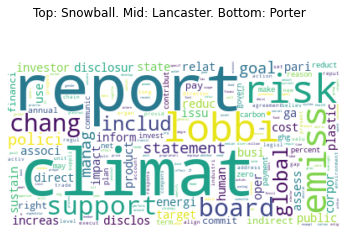

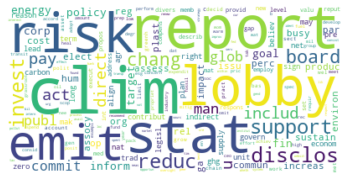

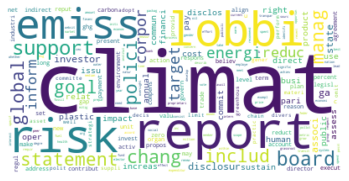

In [16]:
#plot the wordclouds together
stem = (word_cloud_snow,word_cloud_lanc,word_cloud_port)
fig = plt.figure()
fig.suptitle('Top: Snowball. Mid: Lancaster. Bottom: Porter')
for s in (stem):
    plt.imshow(s, interpolation='bilinear')
    plt.axis("off")
    plt.show()
#first plot is snowball, second is lancaster, third is porter

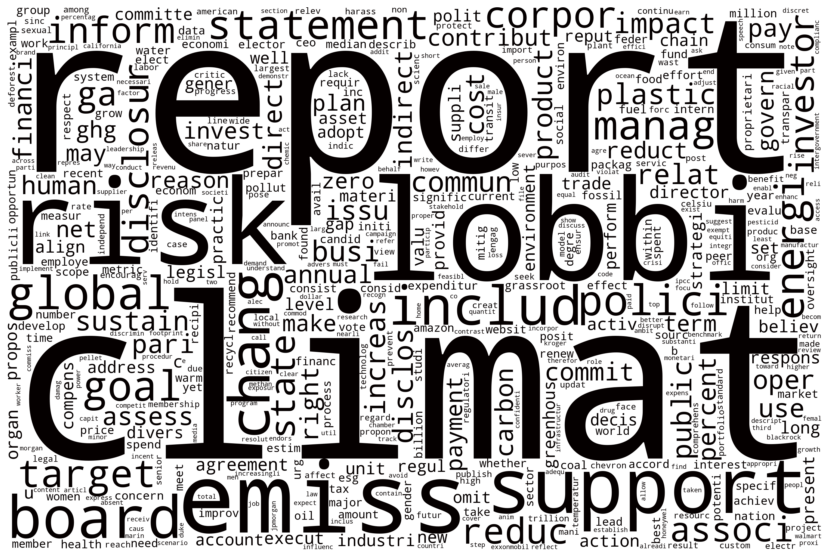

In [17]:
#this visualization formatting code was shared with me by Leaha Nagy, a fellow Metis data scientist.
#The porter stemmer is used
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 5000
# set width and height to higher quality, 3000 x 2000
word_cloud = WordCloud(collocations = False, background_color = 'white',width=3000, height=2000, max_words=500).generate(text_port)
# set the word color to black
word_cloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(word_cloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('word_cloud_all.png')

## Document Term Matrix (dtm)

This is a matrix that counts the number of times each word is used in a document. The dtm is then used with non-negative matrix factorization (nmf) for topic modeling. 

In [18]:
#create a list of the stemmed series, for use in the countvectorizer
corpus_port = list(df.porter)
corpus_lanc = list(df.lancaster)
corpus_snow = list(df.snowball)

In [19]:
#this code uses the first 100 characters from the resolution title as the index for the dataframe--this aids with interpretability
indx_label = [e[:100]+"..." for e in df.title]

In [20]:
#Some calculations regarding max term inclusion
921*.99

911.79

In [21]:
#countvectorizer creates the dtm. Here I use the porter stemmed corpus
#with min_df = 6 I am excluding terms that occur in more than 6 documents (this got rid of the name Zuckerberg, an arbitrary but effective cutoff),
#with max_df = .99, I am excluding terms that occur in more than 99% of the documents (which is about 912 documents). This is conservative and could be more aggressive

#ngrams explored here include uni-gram, bi-gram, and tri-gram. I want to see if words used in proximity occur at great enough 
#frequency to be significant. 

#I'm also removing any stop words via countvectorizer that made it through the earlier regex stop word removal

cv = CountVectorizer(stop_words = 'english', min_df = 6, max_df = .99, ngram_range=(1, 3))
#using the porter stemmed data for the dtm
X_port = cv.fit_transform(corpus_port)
dtm_port = pd.DataFrame(X_port.toarray(), index=indx_label, columns=cv.get_feature_names_out())
dtm_port

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#take a look at features names and tune cv parameters if desired
cv.get_feature_names()

['ab',
 'abandon',
 'abbvi',
 'abil',
 'abil compet',
 'abil compet adapt',
 'abil comprehens',
 'abil comprehens evalu',
 'abl',
 'abl fulli',
 'abl fulli evalu',
 'abroad',
 'abroad spend',
 'abroad spend lobbi',
 'absenc',
 'absent',
 'absent exampl',
 'absent state',
 'absent studi',
 'absolut',
 'absolut elimin',
 'absolut elimin ton',
 'absolut emiss',
 'absolut emiss energi',
 'absolut emiss reduct',
 'absolut net',
 'absolut net energi',
 'absorb',
 'absorb toxic',
 'absorb toxin',
 'absorb toxin dioxin',
 'abus',
 'academ',
 'academ studi',
 'academi',
 'academi pediatr',
 'acceler',
 'accept',
 'accept platform',
 'accept platform suggest',
 'access',
 'access person',
 'access person document',
 'access pipelin',
 'accompani',
 'accomplish',
 'accord',
 'accord american',
 'accord bank',
 'accord bank climat',
 'accord believ',
 'accord best',
 'accord best avail',
 'accord bloomberg',
 'accord bloomberg new',
 'accord california',
 'accord california transpar',
 'accord gen

## NMF

Here the words in the corpus will be clusterd into use groups. Then I will choose a lable or "topic" for each cluster. This is the topic modeling step.

In [22]:
#A paper on a similar project by Raghupathi et al. (Sustainability, 2020) used 7 key topics, based on k-means clustering. 
#Through trial and error, this seems like a good number for me. Beyond 7 topics, I see repetition. Below seven, some significant topics/terms are omitted 

#A NEXT STEP! I would like to use nmf coherence score to optimize the number of topics. Initiallize with nndsvda
#nndsvda = non negative double singular value decomposition is a new method designed to enhance the initialization stage of the nonnegative matrix factorization. The basic algorithm contains no randomization and is based on two SVD processes, one approximating the data matrix, the other approximating positive sections of the resulting partial SVD factors utilizing an algebraic property of unit rank matrices.
#NNDSVD is well suited to initialize NMF algorithms with sparse factors. Numerical examples suggest that NNDSVD leads to rapid reduction of the approximation error of many NMF algorithms. By setting algorithm options :param:`flag` dense factors can be generated.

nmf = NMF(7, init = "nndsvda") 
nmf.fit(dtm_port)

NMF(init='nndsvda', n_components=7)

In [23]:
#now create the topic-term-matrix, with three significant digits.
topic_term = nmf.components_.round(3)
topic_term.shape

(7, 15040)

In [24]:
#and turn it into a dataframe with topic cluster as rows, and terms as columns
topic_term_df = pd.DataFrame(topic_term, columns = cv.get_feature_names_out())
topic_term_df

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
0,0.010,0.004,0.095,0.261,0.086,0.086,0.07,0.07,0.073,0.000,...,0.000,0.000,0.000,0.017,0.017,0.000,0.000,0.002,0.017,0.000
1,0.003,0.000,0.158,0.033,0.000,0.000,0.00,0.00,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.001,0.000,0.000,0.000,0.000,0.00,0.00,0.002,0.000,...,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.002
3,0.000,0.000,0.006,0.000,0.000,0.000,0.00,0.00,0.091,0.082,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.009,0.002,0.000,0.023,0.000,0.000,0.00,0.00,0.000,0.000,...,0.000,0.003,0.003,0.003,0.003,0.000,0.000,0.000,0.000,0.000
5,0.001,0.004,0.000,0.084,0.000,0.000,0.00,0.00,0.006,0.000,...,0.000,0.000,0.000,0.012,0.012,0.000,0.000,0.001,0.000,0.000
6,0.011,0.029,0.000,0.000,0.000,0.000,0.00,0.00,0.008,0.000,...,0.062,0.032,0.032,0.003,0.003,0.031,0.026,0.034,0.033,0.250


In [25]:
# This function displays the top n terms in each topic--this code is from Metis course material

def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [26]:
output = display_topics(nmf, cv.get_feature_names_out(), 10)


Topic  1
report, sustain, risk, board, manag, esg, execut, polici, corpor, issu

Topic  2
lobbi, commun, payment, legisl, indirect, direct, grassroot, indirect lobbi, grassroot lobbi, direct indirect

Topic  3
pay, gap, pay gap, percent, median, women, report, gender, unit, gender pay

Topic  4
corpor, elector, spend, polit, contribut, support, includ, board, elect, expenditur

Topic  5
plastic, packag, recycl, reduc, report, pollut, plastic packag, ocean, plastic pollut, product

Topic  6
right, human, human right, risk, impact, assess, busi, chain, labor, oper

Topic  7
climat, emiss, target, chang, energi, climat chang, goal, ga, risk, global




In [27]:
#now apply my own labels to the topic clusters, and show top 5 terms per topic
display_topics(nmf, cv.get_feature_names_out(), 5, [
    '1. ESG Management and Corporate Policies', 
    '2. Activism/Lobbying', 
    '3. Female Wage Disparity',
    '4. Campaign Contributions', 
    '5. Plastic Pollution, Recycling and the Ocean',
    '6. Human Rights Impact Assessments', 
    '7. Climate Emissions Goals'
]);

# when more topics are included, some that show up (after the first topic has repeated a few times) are:
#    '9. Financing fossil fuels/warming/ ',
#    '10. Compensation reviews for ceos and employees',
#    '14. water use and management',
#    '16. natural gas and liquified natural gas, methane and emissions',
#    '17. plastic pellets polution, chemical spills',
#    '18. corporate leaders and accountability',
#    '19. gender diversity in tech',
#    '20. sexual harassment reporting',
# Human labor and the supply chain
# Green house gas net zero
# renewable energy climate change goals
# paris climate agreement
# deforestation, supply chain risks
# drug prices (for seniors)
# plant based proteins, heinz and kraft
# sexual harassment reporting
# water risks and plastic pellets



Topic:  1. ESG Management and Corporate Policies
report, sustain, risk, board, manag

Topic:  2. Activism/Lobbying
lobbi, commun, payment, legisl, indirect

Topic:  3. Female Wage Disparity
pay, gap, pay gap, percent, median

Topic:  4. Campaign Contributions
corpor, elector, spend, polit, contribut

Topic:  5. Plastic Pollution, Recycling and the Ocean
plastic, packag, recycl, reduc, report

Topic:  6. Human Rights Impact Assessments
right, human, human right, risk, impact

Topic:  7. Climate Emissions Goals
climat, emiss, target, chang, energi




In [28]:
#now create the document-topic matrix for the porter stemmed terms(earlier we had the nmf topic-term matrix)
doc_topic = nmf.transform(dtm_port)
doc_topic.shape

(921, 7)

In [29]:
#and turn it into a dataframe for further use and interpretability
#The higher the score, the more the topic label/category fits the document

doc_topic_df = pd.DataFrame(doc_topic.round(5), index = indx_label, columns = [
    '1. ESG Management and Corporate Policies', 
    '2. Activism/Lobbying', 
    '3. Female Wage Disparity',
    '4. Campaign Contributions', 
    '5. Plastic Pollution, Recycling and the Ocean',
    '6. Human Rights Impact Assessments', 
    '7. Climate Emissions Goals' 
])
doc_topic_df.index.name = 'indx_label'
doc_topic_df

,1. ESG Management and Corporate Policies,2. Activism/Lobbying,3. Female Wage Disparity,4. Campaign Contributions,"5. Plastic Pollution, Recycling and the Ocean",6. Human Rights Impact Assessments,7. Climate Emissions Goals
indx_label,,,,,,,
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0.52470,0.04145,0.02893,0.00000,0.08302,0.07424,0.16318
Report on lobbying...,0.03924,1.45790,0.00798,0.00722,0.02065,0.00000,0.00000
Report on lobbying in line with company values/policy...,0.22390,0.17386,0.06527,0.23760,0.02631,0.09327,0.14625
Adopt GHG reduction targets...,0.00000,0.00000,0.00000,0.00000,0.00089,0.03061,0.38153
Adopt GHG reduction targets...,0.00000,0.00000,0.00000,0.00000,0.00129,0.00000,1.15881
...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0.24313,0.03586,0.02015,0.06755,0.07780,0.36889,0.21784
Report on pay disparity...,0.40941,0.00000,0.70901,0.00000,0.00000,0.00000,0.00000
Report on lobbying...,0.00000,2.08912,0.06252,0.00000,0.00000,0.00000,0.00000


In [30]:
#this code from stackexchange

# find the column name of maximum values in every row
maxValueIndex = doc_topic_df.idxmax(axis = 1)
 
maxValueIndex_df = pd.DataFrame(maxValueIndex, columns=['topic'])
maxValueIndex_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 921 entries, Adopt stewardship practices to reduce diversified portfolio ESG costs... to Report on lobbying...
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   921 non-null    object
dtypes: object(1)
memory usage: 14.4+ KB


In [31]:
#now we have a dataframe with (first 100 characters of ) resolution titles and the best topic label for that resolution
maxValueIndex_df.head(50)
#not a perfect match in every instance. This can be fine-tuned by further adjusting the number of topics during nmf
#optimizing the number of terms would be beneficial here

,topic
indx_label,
Adopt stewardship practices to reduce diversified portfolio ESG costs...,1. ESG Management and Corporate Policies
Report on lobbying...,2. Activism/Lobbying
Report on lobbying in line with company values/policy...,4. Campaign Contributions
Adopt GHG reduction targets...,7. Climate Emissions Goals
Adopt GHG reduction targets...,7. Climate Emissions Goals
Report on benefits of product repair...,6. Human Rights Impact Assessments
Report on water use risks...,1. ESG Management and Corporate Policies
Report on ESG risks to diversified investors...,1. ESG Management and Corporate Policies
Establish board committee on sustainability...,1. ESG Management and Corporate Policies


In [35]:
#Prepare to merge the new topics lable df with the original df, for further exploration and analysis (eg changes over time!)
#create a df for the left side of merge and a df for right side of merge.
left = df.drop(['status', 'organization', 'filtered','title', 'filed_by',
       'preprocessed', 'lancaster', 'snowball', 'tokenized', 'whereas'
       ], axis = 1)
#label the index uniquely and consistently 
s = pd.Series(range(1,922))

left['indx_label'] = [e[:100]+"..." for e in df.title]
left.set_index([s, indx_label], inplace = True)
right = maxValueIndex_df
right.set_index([s, indx_label], inplace = True)

In [36]:
#merge!
result = pd.merge(left, right, left_index= True, right_index = True)

In [37]:
result

,,year,porter,indx_label,topic
1,Adopt stewardship practices to reduce diversified portfolio ESG costs...,2022,sustain report ceo mike roman state commit lea...,Adopt stewardship practices to reduce diversif...,1. ESG Management and Corporate Policies
2,Report on lobbying...,2022,believ disclosur abbott laboratori abbott dire...,Report on lobbying...,2. Activism/Lobbying
3,Report on lobbying in line with company values/policy...,2022,polit expenditur abbvi inc appear misalign pub...,Report on lobbying in line with company values...,4. Campaign Contributions
4,Adopt GHG reduction targets...,2022,air product address risk opportun present clim...,Adopt GHG reduction targets...,7. Climate Emissions Goals
5,Adopt GHG reduction targets...,2022,increas rate number climat relat disast affect...,Adopt GHG reduction targets...,7. Climate Emissions Goals
...,...,...,...,...,...
917,Report on supply chain deforestation impacts...,2019,mondel z intern inc mondelez report annual ini...,Report on supply chain deforestation impacts...,6. Human Rights Impact Assessments
918,Report on pay disparity...,2019,mondelez intern inc compens committe board dir...,Report on pay disparity...,3. Female Wage Disparity
919,Report on lobbying...,2019,believ disclosur morgan stanley direct indirec...,Report on lobbying...,2. Activism/Lobbying
920,Nominate human rights expert to board...,2019,motorola solut inc global corpor face increasi...,Nominate human rights expert to board...,6. Human Rights Impact Assessments


### Topic Modeling Subset--Human Rights Impacts Assessments (hria)

In [39]:
hria_df = result.loc[result['topic'] == "6. Human Rights Impact Assessments"]
hria_df

,,year,porter,indx_label,topic
6,Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
20,Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
42,Conduct independent racial equity audit and disclose findings...,2022,racial inequ environment racism system risk th...,Conduct independent racial equity audit and di...,6. Human Rights Impact Assessments
49,Report on indigenous peoples policy...,2022,intern recogn standard indigen peopl right un ...,Report on indigenous peoples policy...,6. Human Rights Impact Assessments
58,Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
...,...,...,...,...,...
900,Report on human rights risk assessment...,2019,recent global estim found million peopl trap c...,Report on human rights risk assessment...,6. Human Rights Impact Assessments
907,Establish board committee on human rights...,2019,mastercard incorpor mastercard board direct no...,Establish board committee on human rights...,6. Human Rights Impact Assessments
913,Conduct a human rights impact assessment...,2019,estim million peopl trap condit forc labor ext...,Conduct a human rights impact assessment...,6. Human Rights Impact Assessments
917,Report on supply chain deforestation impacts...,2019,mondel z intern inc mondelez report annual ini...,Report on supply chain deforestation impacts...,6. Human Rights Impact Assessments


In [73]:
hria_stop_words = ['right', 'human', 'impact', 'risk', 'assess', 
                   'suppli','chain'
                   #'busi', 
                           ]

#stop_words = stopwords.words('english')
#stop_words3 = list(stop_words)

#for word in my_additional_stop_words:
#    stop_words2.append(word)

In [74]:
#now create a column with stop words removed    
hria_df['hria_filtered'] = hria_df.porter.apply(lambda x: ' '.join([word for word in x.split() if word not in (hria_stop_words)]))
hria_df

,year,porter,indx_label,topic,title,hria_filtered
title,,,,,,
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments,Report on benefits of product repair...,greenhous ga emiss result internet connect tec...
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments,Report on benefits of product repair...,greenhous ga emiss result internet connect tec...
Conduct independent racial equity audit and disclose findings...,2022,racial inequ environment racism system risk th...,Conduct independent racial equity audit and di...,6. Human Rights Impact Assessments,Conduct independent racial equity audit and di...,racial inequ environment racism system threate...
Report on indigenous peoples policy...,2022,intern recogn standard indigen peopl right un ...,Report on indigenous peoples policy...,6. Human Rights Impact Assessments,Report on indigenous peoples policy...,intern recogn standard indigen peopl un declar...
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments,Report on benefits of product repair...,greenhous ga emiss result internet connect tec...
...,...,...,...,...,...,...
Report on human rights risk assessment...,2019,recent global estim found million peopl trap c...,Report on human rights risk assessment...,6. Human Rights Impact Assessments,Report on human rights risk assessment...,recent global estim found million peopl trap c...
Establish board committee on human rights...,2019,mastercard incorpor mastercard board direct no...,Establish board committee on human rights...,6. Human Rights Impact Assessments,Establish board committee on human rights...,mastercard incorpor mastercard board direct no...
Conduct a human rights impact assessment...,2019,estim million peopl trap condit forc labor ext...,Conduct a human rights impact assessment...,6. Human Rights Impact Assessments,Conduct a human rights impact assessment...,estim million peopl trap condit forc labor ext...


In [48]:
hria_df = hria_df.droplevel(level=0)
hria_df['title'] = hria_df.index
hria_df

,year,porter,indx_label,topic
title,,,,
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
Conduct independent racial equity audit and disclose findings...,2022,racial inequ environment racism system risk th...,Conduct independent racial equity audit and di...,6. Human Rights Impact Assessments
Report on indigenous peoples policy...,2022,intern recogn standard indigen peopl right un ...,Report on indigenous peoples policy...,6. Human Rights Impact Assessments
Report on benefits of product repair...,2022,greenhous ga emiss result internet connect tec...,Report on benefits of product repair...,6. Human Rights Impact Assessments
...,...,...,...,...
Report on human rights risk assessment...,2019,recent global estim found million peopl trap c...,Report on human rights risk assessment...,6. Human Rights Impact Assessments
Establish board committee on human rights...,2019,mastercard incorpor mastercard board direct no...,Establish board committee on human rights...,6. Human Rights Impact Assessments
Conduct a human rights impact assessment...,2019,estim million peopl trap condit forc labor ext...,Conduct a human rights impact assessment...,6. Human Rights Impact Assessments


In [75]:
corpus_hria = list(hria_df.hria_filtered)
indx_label_hria = [e[:100]+"..." for e in hria_df.title]

In [76]:
X_hria = cv.fit_transform(corpus_hria)
dtm_hria = pd.DataFrame(X_hria.toarray(), index=indx_label_hria, columns=cv.get_feature_names_out())

In [98]:
nmf_hria = NMF(7, init = "nndsvda") 
nmf_hria.fit(dtm_hria)

NMF(init='nndsvda', n_components=7)

In [99]:
topic_term_hria = nmf_hria.components_.round(3)
topic_term_hria.shape

(7, 1389)

In [100]:
topic_term_hria_df = pd.DataFrame(topic_term_hria, columns = cv.get_feature_names_out())
topic_term_hria_df

,abil,absenc,abus,accept,access,access person,access person document,accord,accord california,accord california transpar,...,worker recruit debt,workplac,world,wp,wp content,wp content upload,year,york,york time,zero
0,0.375,0.000,0.231,0.022,0.153,0.000,0.000,0.070,0.000,0.000,...,0.000,0.906,0.090,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.002,0.000,0.463,0.464,0.464,0.551,0.423,0.423,...,0.464,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.004,0.423,0.000,0.000,0.000,0.000,0.000,0.044,0.000,0.000,...,0.000,0.000,0.161,0.000,0.000,0.000,0.251,0.000,0.000,0.000
3,0.015,0.000,0.261,0.000,0.476,0.000,0.000,0.253,0.000,0.000,...,0.000,0.000,0.330,0.117,0.117,0.117,0.183,0.283,0.231,0.490
4,0.000,0.002,0.123,0.000,0.035,0.000,0.000,0.036,0.000,0.000,...,0.000,0.000,0.043,0.000,0.000,0.000,0.001,0.000,0.005,0.000
5,0.130,0.014,0.408,0.267,0.624,0.000,0.000,0.327,0.000,0.000,...,0.000,0.064,0.160,0.000,0.000,0.000,0.476,0.170,0.046,0.000
6,0.000,0.003,0.027,0.000,0.405,0.000,0.000,0.074,0.000,0.000,...,0.000,0.000,0.099,0.341,0.341,0.341,0.000,0.050,0.006,0.017


In [101]:
output_hria = display_topics(nmf_hria, cv.get_feature_names_out(), 15)


Topic  1
busi, mitig, oper, advers, commun, prevent, water, report, prevent mitig, worker, effect, inform, identifi, dilig, health

Topic  2
labor, forc, forc labor, worker, report, maci, inform, wage, slaveri, traffick, respect, bondag, debt, debt bondag, requir

Topic  3
anim, welfar, anim welfar, polici, ethic, valu, regard, statement, ensur, cruelti, adopt, vendor, enhanc, report, treatment

Topic  4
deforest, forest, report, commod, sourc, includ, product, commit, climat, global, support, time, palm, soy, oil

Topic  5
prison, labor, supplier, reput, work, produc, servic, polici, product, audit, forc, support, statement, oper, support statement

Topic  6
busi, board, govern, civil, polici, support, director, facebook, report, unit, technolog, nation, state, amazon, issu

Topic  7
com, line, org, report, environment, peopl, indigen, commun, racial, water, pollut, financ, social, indigen peopl, news




*"Suppli chain" appeared in every topic, so I removed those words.*

When 10 topics were run, we saw repitition bewteen Topic 4 and 9. 

Topic  1
deforest, suppli, chain, suppli chain, forest, commod, sourc, report, includ, commit

Topic  2
labor, forc, forc labor, worker, chain, suppli chain, suppli, report, maci, inform

Topic  3
busi, mitig, advers, oper, commun, prevent, water, report, prevent mitig, worker

Topic  4
anim, anim welfar, welfar, polici, ethic, valu, chain, suppli chain, suppli, regard

Topic  5
prison, labor, chain, suppli chain, suppli, supplier, reput, work, produc, servic

Topic  6
busi, board, polici, committe, nation, group, principl, director, public, develop

Topic  7
line, com, indigen, org, peopl, water, financ, indigen peopl, project, intern

Topic  8
civil, govern, technolog, amazon, report, facebook, surveil, privaci, googl, board

Topic  9
medic, import, product, resist, anim, suppli, chain, suppli chain, report, meat

Topic  10
com, environment, commun, report, racial, audit, pollut, justic, oper, color


In [105]:
display_topics(nmf_hria, cv.get_feature_names_out(), 10, [
    '1. Water Mitigation Whistle blowing?', 
    '2. Forced Labor/Slavery/Human Trafficking', 
    '3. Animal Welfare/Cruelty',
    '4. Deforestation', 
    '5. Prison Labor',
    '6. Tech Industry Overreach/Surveillance', 
    '7. Indigenous Communities Rights'
]);


Topic:  1. Water Mitigation Whistle blowing?
busi, mitig, oper, advers, commun, prevent, water, report, prevent mitig, worker

Topic:  2. Forced Labor/Slavery/Human Trafficking
labor, forc, forc labor, worker, report, maci, inform, wage, slaveri, traffick

Topic:  3. Animal Welfare/Cruelty
anim, welfar, anim welfar, polici, ethic, valu, regard, statement, ensur, cruelti

Topic:  4. Deforestation
deforest, forest, report, commod, sourc, includ, product, commit, climat, global

Topic:  5. Prison Labor
prison, labor, supplier, reput, work, produc, servic, polici, product, audit

Topic:  6. Tech Industry Overreach/Surveillance
busi, board, govern, civil, polici, support, director, facebook, report, unit

Topic:  7. Indigenous Communities Rights
com, line, org, report, environment, peopl, indigen, commun, racial, water




## Topic over time

In [119]:
#trying to convert the year column to date_time type
#probably not necessary
result['year'] = pd.to_datetime(result['year'],format = "%Y")
#result['year'] = result['year'].dt.year
#pd.to_datetime(result.year,format = "%Y")
result.info()
result

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 921 entries, (1, 'Adopt stewardship practices to reduce diversified portfolio ESG costs...') to (921, 'Report on lobbying...')
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        921 non-null    datetime64[ns]
 1   porter      921 non-null    object        
 2   indx_label  921 non-null    object        
 3   topic       921 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 109.5+ KB


,,year,porter,indx_label,topic
1,Adopt stewardship practices to reduce diversified portfolio ESG costs...,2022-01-01,sustain report ceo mike roman state commit lea...,Adopt stewardship practices to reduce diversif...,1. ESG Management and Corporate Policies
2,Report on lobbying...,2022-01-01,believ disclosur abbott laboratori abbott dire...,Report on lobbying...,2. Activism/Lobbying
3,Report on lobbying in line with company values/policy...,2022-01-01,polit expenditur abbvi inc appear misalign pub...,Report on lobbying in line with company values...,4. Campaign Contributions
4,Adopt GHG reduction targets...,2022-01-01,air product address risk opportun present clim...,Adopt GHG reduction targets...,7. Climate Emissions Goals
5,Adopt GHG reduction targets...,2022-01-01,increas rate number climat relat disast affect...,Adopt GHG reduction targets...,7. Climate Emissions Goals
...,...,...,...,...,...
917,Report on supply chain deforestation impacts...,2019-01-01,mondel z intern inc mondelez report annual ini...,Report on supply chain deforestation impacts...,6. Human Rights Impact Assessments
918,Report on pay disparity...,2019-01-01,mondelez intern inc compens committe board dir...,Report on pay disparity...,3. Female Wage Disparity
919,Report on lobbying...,2019-01-01,believ disclosur morgan stanley direct indirec...,Report on lobbying...,2. Activism/Lobbying
920,Nominate human rights expert to board...,2019-01-01,motorola solut inc global corpor face increasi...,Nominate human rights expert to board...,6. Human Rights Impact Assessments


In [169]:
result.value_counts('topic')#.sort_index()

topic
7. Climate Emissions Goals                       320
1. ESG Management and Corporate Policies         229
2. Activism/Lobbying                             105
6. Human Rights Impact Assessments                95
4. Campaign Contributions                         78
5. Plastic Pollution, Recycling and the Ocean     52
3. Female Wage Disparity                          42
dtype: int64

In [177]:
topic_by_year = result.groupby(['year']).count()
print (topic_by_year)

            porter  indx_label  topic
year                                 
2019-01-01     413         413    413
2020-01-01     237         237    237
2021-01-01     111         111    111
2022-01-01     160         160    160


<AxesSubplot:title={'center':'Resolutions per Year'}, xlabel='year'>

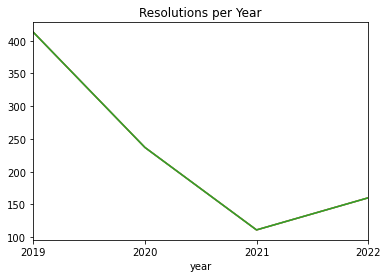

In [182]:
topic_by_year.plot(title = "Resolutions per Year", legend= False)

COVID likely effected the number of resolutions submitted in 2020-2021, as companies shut down or shifted standard operations

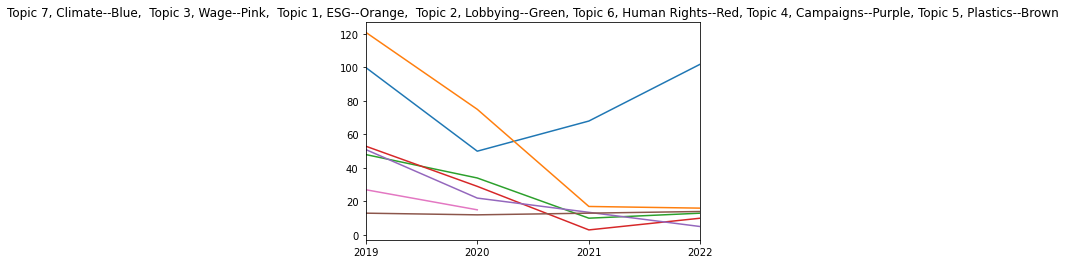

In [183]:
#need to find a better way to label this, or display it, 
topics = ["7. Climate Emissions Goals",
    "1. ESG Management and Corporate Policies",
    "2. Activism/Lobbying",
    "6. Human Rights Impact Assessments",
    "4. Campaign Contributions",
    "5. Plastic Pollution, Recycling and the Ocean",
    "3. Female Wage Disparity"
         ]
for topic in topics:
    temp_df = result.loc[result['topic'] == topic ]
    count_temp  = temp_df['year'].value_counts().sort_index()
    count_temp.plot(title = "Topic 7, Climate--Blue,  Topic 3, Wage--Pink,  Topic 1, ESG--Orange,  Topic 2, Lobbying--Green, Topic 6, Human Rights--Red, Topic 4, Campaigns--Purple, Topic 5, Plastics--Brown")

## Word Count Plot

A nifty visualization

In [184]:
#counting the occurrence of each word in the porter stemmed column
#join the documents into a single list then single string
porter_list = [' '.join(df['porter'])]
porter_str = ' '
for x in porter_list:
    porter_str += ' ' + x

In [186]:
#This function has a string as the input and returns a dictionary "counts" of the count of each word in the string
def word_count(str):
    #set up empty dictionary to compile count
    counts = dict()
    #splits the input string into words (is it a list?)
    words = str.split()

   #iterates through the list of words, adds it to the dictionary or adds another count of the word to the running dictionary 
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

counts = word_count(porter_str)

In [193]:
#sort the dictionary of counts by the descending value--use operator.itemgetter to grab value for sort.
sorted_dict = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True))

#print the dictionary in descending order by value and only use the words that appear more than 900 times
dc = {k: v for k, v in sorted_dict.items() if v > 900}
print(dc)

{'climat': 3204, 'report': 3118, 'lobbi': 2550, 'risk': 2532, 'emiss': 2107, 'support': 1837, 'board': 1755, 'chang': 1650, 'includ': 1486, 'global': 1447, 'polici': 1406, 'goal': 1372, 'statement': 1336, 'manag': 1310, 'energi': 1287, 'target': 1258, 'corpor': 1258, 'inform': 1171, 'reduc': 1158, 'disclosur': 1155, 'state': 1121, 'associ': 1081, 'ga': 1053, 'investor': 1047, 'plastic': 1011, 'impact': 1004, 'busi': 998, 'commun': 976, 'disclos': 938, 'relat': 931, 'increas': 930, 'public': 918, 'sustain': 902}


In [197]:
myList

dict_items([('climat', 3204), ('report', 3118), ('lobbi', 2550), ('risk', 2532), ('emiss', 2107), ('support', 1837), ('board', 1755), ('chang', 1650), ('includ', 1486), ('global', 1447), ('polici', 1406), ('goal', 1372), ('statement', 1336), ('manag', 1310), ('energi', 1287), ('target', 1258), ('corpor', 1258), ('inform', 1171), ('reduc', 1158), ('disclosur', 1155), ('state', 1121), ('associ', 1081), ('ga', 1053), ('investor', 1047), ('plastic', 1011), ('impact', 1004), ('busi', 998), ('commun', 976), ('disclos', 938), ('relat', 931), ('increas', 930), ('public', 918), ('sustain', 902)])

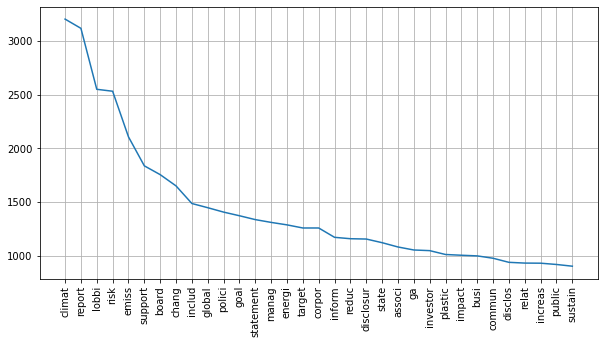

In [200]:
#create line plot!

myList = dc.items() #turns the sorted dictionary of counts into a "dictionary items" list of tuples
x, y = zip(*myList) #establish x as word and y as the count by UNzipping the tuples!

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.grid()
plt.savefig('wordcount.png')
plt.show();

#### Optional comparisons. (Find a way to combine for more inclusive results..)

In [70]:
#can compare portland to snowball stemmer, repeat the above steps to compare! Have fun!
X_snow = cv.fit_transform(corpus_snow)
dtm_snow = pd.DataFrame(X_snow.toarray(), index=indx_label, columns=cv.get_feature_names_out())
#dtm.to_csv('dtm_porter.csv')
dtm_snow

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#can compare portland to Lancaster stemmer, repeat the above steps to compare! Have fun!
X_lanc = cv.fit_transform(corpus_lanc)
dtm_lanc = pd.DataFrame(X_lanc.toarray(), index=indx_label, columns=cv.get_feature_names_out())
#dtm.to_csv('dtm_porter.csv')
dtm_lanc

,ab,abandon,abbvy,abl,abl compet,abl compet adapt,abl comprehend,abl comprehend evalu,abl ful,abl ful evalu,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero ord,zero ord limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sentiment Score

Assigning positive negative or nuetral scores to the unstemmed documents.

In [211]:
corpus_list = list(df.whereas)
corpus_list[0:4] #check to see the corpus is formatted correctly (do not apply sent score to each letter!)

['In our Company’s 2021 Sustainability Report, CEO Mike Roman states, “We are committed to being leaders in sustainability.”1 A review of that report reveals our Company has addressed many environmental concerns. But 3M’s commitment is limited. For example:\n3M is active in three trade associations that work against comprehensive U.S. policies to address climate change.2\n3M does not appear to have committed to meet the Science-Based Targets initiative for a 1.5- degree Celsius world3 and failed to receive an “A” grade in 2020 from CDP, a widely used and respected climate rating.4\nBelgian regulators recently ordered 3M to stop PFAS production after recent blood samples taken from 800 people near 3M’s plant showed elevated levels of PFAS.5\nIt appears our Company only addresses sustainability issues when that pursuit optimizes 3M’s financial return. The Sustainability Report states:\nOur priority is the comprehensive management of enterprise risks through an ethical tone, governance pr

In [284]:
#run the sentiment analyzer--takes a long time on entire corpus
analyzer = SentimentIntensityAnalyzer() 
score1 = analyzer.polarity_scores(corpus_list[0:50])
score2 = analyzer.polarity_scores(corpus_list[50:150])
score3 = analyzer.polarity_scores(corpus_list[150:250])
print(score1, score2, score3) 

{'neg': 0.08, 'neu': 0.799, 'pos': 0.121, 'compound': 1.0} {'neg': 0.073, 'neu': 0.809, 'pos': 0.118, 'compound': 1.0} {'neg': 0.066, 'neu': 0.799, 'pos': 0.135, 'compound': 1.0}


In [213]:
#put scores into df for interpretation. Here, the scores are based on 'whereas'. Consider scores based on stemmed columns?
#The compound score is the sum of the pos, neg, and neutral scores, normalized to -1 and +1.
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['whereas']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['whereas']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['whereas']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['whereas']]
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball,compound,neg,neu,pos
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...,sustainability report ceo mike roman states co...,"[sustainability, report, ceo, mike, roman, sta...",sustain report ceo mike roman state commit lea...,sustain report ceo mik rom stat commit lead su...,sustain report ceo mike roman state commit lea...,0.9697,0.107,0.746,0.147
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...,believe disclosure abbott laboratories abbott ...,"[believe, disclosure, abbott, laboratories, ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...,0.5205,0.115,0.780,0.105
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...,political expenditures abbvie inc appear misal...,"[political, expenditures, abbvie, inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...,0.9956,0.031,0.801,0.168
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...,air products address risks opportunities prese...,"[air, products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...,0.9545,0.013,0.830,0.156
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...,0.2960,0.054,0.883,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,resolved shareholders request that mondel z i...,mondel z international inc mondelez report ann...,"[mondel, z, international, inc, mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...,0.2263,0.084,0.817,0.099
938,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,resolved shareholders of mondelez internation...,mondelez international inc compensation commit...,"[mondelez, international, inc, compensation, c...",mondelez intern inc compens committe board dir...,mondelez intern int compens commit board direc...,mondelez intern inc compens committe board dir...,-0.3626,0.071,0.885,0.044
939,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of morgan stanle...,believe disclosure morgan stanley direct indir...,"[believe, disclosure, morgan, stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...,-0.0275,0.089,0.851,0.060
940,Vote,Nominate human rights expert to board,"Motorol

In [214]:
df.to_csv('sent_score_df.csv')

<AxesSubplot:xlabel='resolution_number', ylabel='compound'>

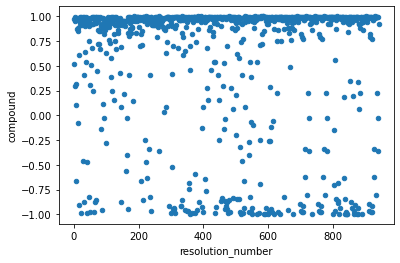

In [255]:
df['resolution_number'] = df.index+1
df.plot(x ='resolution_number', y='compound', kind = 'scatter')

In [224]:
df2 = df
df2['indx_label'] = [e[:100]+"..." for e in df.title]
df2 = df2[['indx_label','compound','neg','neu','pos']]
left2 = df2
left2.set_index([s, indx_label], inplace = True)
right2 = result
#right.set_index([s, indx_label], inplace = True)
topic_sent_df = pd.merge(left2, right2, left_index= True, right_index = True)

In [231]:
topic_sent_df = topic_sent_df[['topic','compound','neg','neu','pos']]
topic_sent_df

,,topic,compound,neg,neu,pos
1,Adopt stewardship practices to reduce diversified portfolio ESG costs...,1. ESG Management and Corporate Policies,0.9697,0.107,0.746,0.147
2,Report on lobbying...,2. Activism/Lobbying,0.5205,0.115,0.780,0.105
3,Report on lobbying in line with company values/policy...,4. Campaign Contributions,0.9956,0.031,0.801,0.168
4,Adopt GHG reduction targets...,7. Climate Emissions Goals,0.9545,0.013,0.830,0.156
5,Adopt GHG reduction targets...,7. Climate Emissions Goals,0.2960,0.054,0.883,0.064
...,...,...,...,...,...,...
917,Report on supply chain deforestation impacts...,6. Human Rights Impact Assessments,0.2263,0.084,0.817,0.099
918,Report on pay disparity...,3. Female Wage Disparity,-0.3626,0.071,0.885,0.044
919,Report on lobbying...,2. Activism/Lobbying,-0.0275,0.089,0.851,0.060
920,Nominate human rights expert to board...,6. Human Rights Impact Assessments,0.9920,0.026,0.849,0.125


#### Average Compound Score by Topic

In [253]:
#This function has dataframe input and outputs a dictionary with average compound sentiment score per topic
def topic_score(topic_sent_df):
    #set up empty dictionary to compile count
    avg_score_dict = dict()    
    for topic in topics: #Topics was assigned a value earlier in the notebook
        score = topic_sent_df.loc[topic_sent_df['topic'] == topic, 'compound'].mean()
        avg_score_dict[topic] = round(score, 2)

    return avg_score_dict

topic_sent_score = topic_score(topic_sent_df)

In [254]:
sorted(topic_sent_score.items())

[('1. ESG Management and Corporate Policies', 0.54),
 ('2. Activism/Lobbying', 0.45),
 ('3. Female Wage Disparity', 0.76),
 ('4. Campaign Contributions', 0.99),
 ('5. Plastic Pollution, Recycling and the Ocean', 0.36),
 ('6. Human Rights Impact Assessments', -0.09),
 ('7. Climate Emissions Goals', 0.81)]

In [258]:
#from geeksforgeeks
def list_to_dict (tup, di):
    di = dict(tup)
    return di
tups = topic_sent_score
dictionary = {}
bar_data = list_to_dict(tups, dictionary)
bar_data

{'7. Climate Emissions Goals': 0.81,
 '1. ESG Management and Corporate Policies': 0.54,
 '2. Activism/Lobbying': 0.45,
 '6. Human Rights Impact Assessments': -0.09,
 '4. Campaign Contributions': 0.99,
 '5. Plastic Pollution, Recycling and the Ocean': 0.36,
 '3. Female Wage Disparity': 0.76}

In [274]:
sorted_dict= dict(sorted(bar_data.items(), key=operator.itemgetter(1),reverse=True))
sorted_dict

{'4. Campaign Contributions': 0.99,
 '7. Climate Emissions Goals': 0.81,
 '3. Female Wage Disparity': 0.76,
 '1. ESG Management and Corporate Policies': 0.54,
 '2. Activism/Lobbying': 0.45,
 '5. Plastic Pollution, Recycling and the Ocean': 0.36,
 '6. Human Rights Impact Assessments': -0.09}

In [270]:
data = bar_data
topics2 = list(data.keys())
sentiments2 = list(data.values())

#fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
#plt.bar(topics2, sentiments2, color ='maroon',
#        width = 0.4)
 
#plt.xlabel("Courses offered")
#plt.ylabel("No. of students enrolled")
#plt.title("Students enrolled in different courses")
#plt.show()

[0.81, 0.54, 0.45, -0.09, 0.99, 0.36, 0.76]

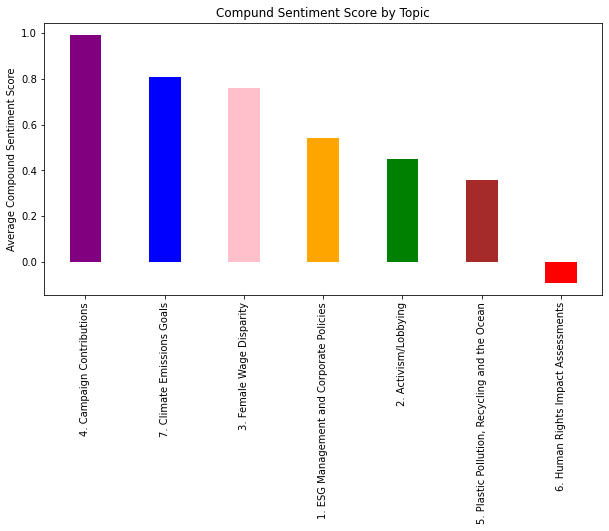

In [282]:
import numpy as np
import matplotlib.pyplot as plt

  
# creating the dataset
#data = {'C':20, 'C++':15, 'Java':30,
#        'Python':35}
data = sorted_dict

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color=['purple', 'blue', 'pink', 'orange', 'green', 'brown', 'red'],
        width = 0.4)
 
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("Average Compound Sentiment Score")
plt.title("Compund Sentiment Score by Topic")
plt.show()

## Linear Regression on Salary Data

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, KFold)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

In [195]:
# from kaggle https://www.kaggle.com/datasets/fedesoriano/gender-pay-gap-dataset

salary_df = pd.read_csv(r'PanelStudyIncomeDynamics.csv')
salary_df = salary_df[['sex','region','age','yrsexp', 'annlabinc']]
salary_df.rename(columns = {'annlabinc':'salary'}, inplace = True)
salary_df=salary_df.dropna(subset=['region'])
salary_df

,sex,region,age,yrsexp,salary
0,1,1.0,34,12.0,10000.0
1,1,2.0,32,14.0,9095.0
2,1,1.0,64,39.0,45200.0
3,1,2.0,50,30.0,25000.0
4,1,3.0,26,8.0,24500.0
...,...,...,...,...,...
33393,2,1.0,34,16.0,37000.0
33394,2,2.0,54,35.0,22198.0
33395,2,3.0,33,3.0,7488.0
33396,2,3.0,25,6.0,18000.0


In [196]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33395 entries, 0 to 33397
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     33395 non-null  int64  
 1   region  33395 non-null  float64
 2   age     33395 non-null  int64  
 3   yrsexp  33395 non-null  float64
 4   salary  33395 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.5 MB


In [197]:
salary_df.describe()

,sex,region,age,yrsexp,salary
count,33395.000000,33395.000000,33395.000000,33395.000000,3.339500e+04
mean,1.513849,2.592155,40.468813,18.105824,3.708803e+04
std,0.499816,0.929496,10.401381,9.387863,4.156644e+04
min,1.000000,1.000000,25.000000,0.000000,3.000000e+01
25%,1.000000,2.000000,31.000000,10.000000,1.600000e+04
50%,2.000000,3.000000,39.000000,17.000000,2.900000e+04
75%,2.000000,3.000000,49.000000,25.000000,4.600000e+04
max,2.000000,4.000000,64.000000,46.000000,1.500000e+06


In [192]:
salary_df.sort_values(by = ['salary']).tail(50)

,sex,age,yrsexp,salary,regions
4957,1,60,34.0,359074.0,Pacific
3086,1,55,31.0,365000.0,Pacific
14046,1,45,20.0,380000.0,Pacific
12540,1,53,27.0,380000.0,Pacific
4691,1,57,32.0,390000.0,Pacific
14924,1,63,35.0,390000.0,Mountain
13102,1,52,28.0,400000.0,Mountain
9265,1,37,19.0,400000.0,Eastern
9168,1,36,15.0,400000.0,Eastern
12447,1,54,30.0,405000.0,Central


In [198]:
salary_df = salary_df[salary_df['salary'] > 10000]
salary_df = salary_df[salary_df['salary'] < 50000]
salary_df.describe()

,sex,region,age,yrsexp,salary
count,21495.000000,21495.000000,21495.000000,21495.000000,21495.000000
mean,1.526401,2.598883,39.725145,17.882645,27425.371714
std,0.499314,0.904214,10.272862,9.244674,10553.629323
min,1.000000,1.000000,25.000000,0.000000,10003.000000
25%,1.000000,2.000000,31.000000,10.000000,18400.000000
50%,2.000000,3.000000,38.000000,16.000000,26500.000000
75%,2.000000,3.000000,48.000000,24.000000,35000.000000
max,2.000000,4.000000,64.000000,46.000000,49920.000000


In [199]:
salary_df.to_csv('salary_df.csv', index= False)

In [148]:
X = salary_df.drop('salary',axis = 1) 
y = salary_df[['salary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1994, random_state=42)

In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26736 entries, 21288 to 15796
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     26736 non-null  int64  
 1   region  26736 non-null  float64
 2   age     26736 non-null  int64  
 3   yrsexp  26736 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.0 MB


In [151]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [152]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [153]:
X_train.describe()

,sex,region,age,yrsexp
count,17110.000000,17110.000000,17110.000000,17110.000000
mean,1.518001,2.594331,40.458212,18.082103
std,0.499690,0.927283,10.354530,9.351077
min,1.000000,1.000000,25.000000,0.000000
25%,1.000000,2.000000,32.000000,10.000000
50%,2.000000,3.000000,39.000000,17.000000
75%,2.000000,3.000000,49.000000,25.000000
max,2.000000,4.000000,64.000000,46.000000


In [157]:
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
scaler.fit(X_train.fillna(0))

StandardScaler()

In [160]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train_scl, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train_scl, y_train)

NameError: name 'LogisticRegression' is not defined

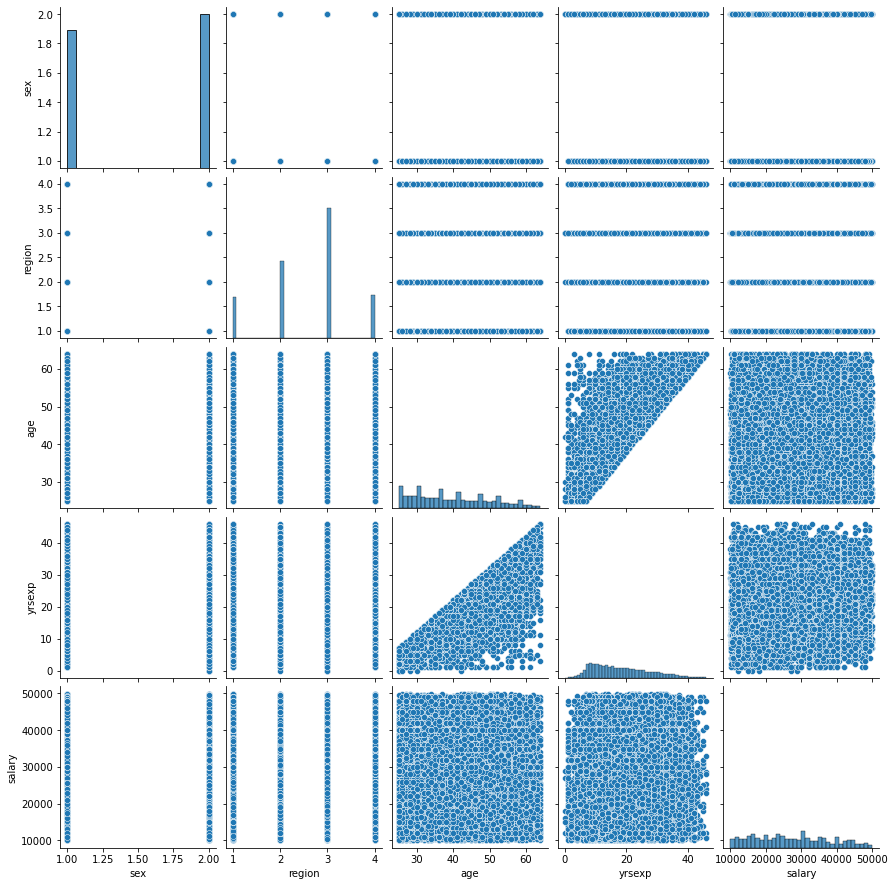

In [173]:
sns.pairplot(salary_df)

In [175]:
sal2_df = pd.read_csv(r'Employee_Salary_Dataset.csv')

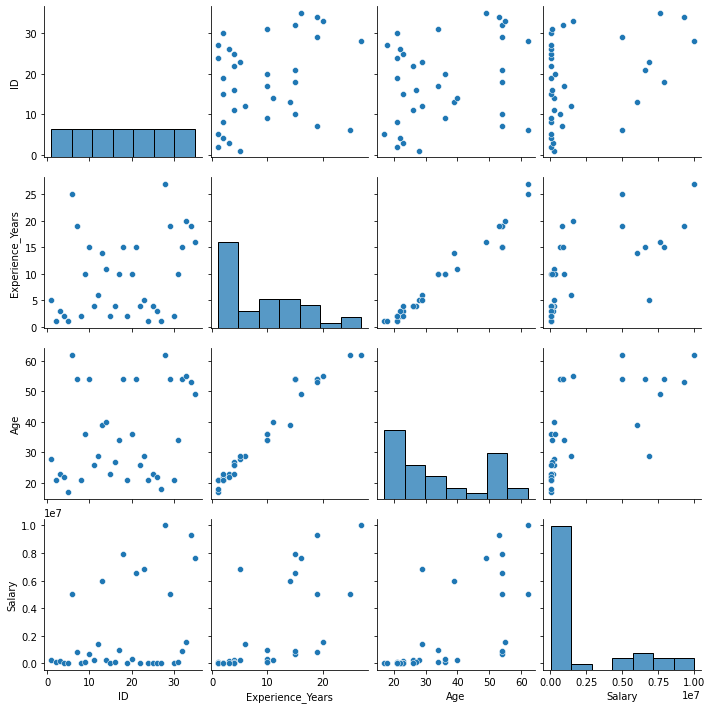

In [176]:
sns.pairplot(sal2_df)

## Get this to work! NMF coherence score
#### (optimize/stabilize the model with the best number of topics)

In [116]:
#https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
#and 
#https://datascience.oneoffcoder.com/topic-modeling-gensim.html

from gensim.corpora import Dictionary

# Use Gensim's NMF to get the best num of topics via coherence score
#texts = porter_list
#Tokenize the sentence into words
tokens = [word for word in porter_str.split()]

top_terms = np.array(tokens)#[top_term_indices]

#Create dictionary
dictionary = corpora.Dictionary([top_terms])
print(dictionary)


# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
#dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(term) for term in top_terms]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

Dictionary<6975 unique tokens: ['a', 'aa', 'aacd', 'aag', 'aar']...>


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [117]:
top_terms

array(['compani', 'sustain', 'report', ..., 'includ', 'trade', 'associ'],
      dtype='<U31')

In [108]:
dataset = ['driving car ',
           'drive car carefully',
           'student and university']

# be sure to split sentence before feed into Dictionary
dataset = [d.split() for d in dataset]

vocab = Dictionary(dataset)

list

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel


In [98]:
#lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
#corpus_lsi = lsi_model[corpus_tfidf]
nmf = NMF(20, init = "nndsvda")

cm = CoherenceModel(model=nmf, texts=texts, coherence='c_v')
cm.get_coherence()

AttributeError: 'NMF' object has no attribute 'id2word'

In [ ]:
cm = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
cm.get_coherence()

## Some next steps:

- In the feature names, some features a combination of multiple words (not bigram, rather missing a space). Find out why...or drop words with a length greather than 2 std dev from the average (stemmed?) word length. 
- Look at coherence score for nmf, find optimal (is it) topic numbers?
- What story can be told about each topic by year
